# [2] Example - Speed

Some example here

In [1]:
import zern.zern_core as zern
import numpy as np
from numpy.random import RandomState
import logging
import matplotlib.pyplot as plt
plt.rc('font', family='sans-serif')

In [2]:
# Parameters
N = 1024
N_zern = 50
rho_max = 1.0
randgen = RandomState(123)  # random seed

First, we create an instance of the **ZernikeNaive** class. This class contains method for calculating the Zernike series using different recursion patterns.

In [3]:
# [0] Construct the coordinates and the aperture mask - simple circ
x = np.linspace(-rho_max, rho_max, N)
xx, yy = np.meshgrid(x, x)
rho = np.sqrt(xx ** 2 + yy ** 2)
theta = np.arctan2(xx, yy)
aperture_mask = rho <= rho_max
rho, theta = rho[aperture_mask], theta[aperture_mask]

In [4]:
z = zern.ZernikeNaive(mask=aperture_mask, log_level=logging.INFO)

INFO: Creating ZernikeNaive instance


In [5]:
# Get the speed measures for all 3 methods of the ZernikeNaive class
coef = randgen.normal(size=N_zern)

r1 = z(coef=coef, rho=rho, theta=theta, normalize_noll=False, mode='Standard', print_option=None)
times_naive = z.times

r2 = z(coef=coef, rho=rho, theta=theta, normalize_noll=False, mode='Jacobi', print_option=None)
times_jacobi = z.times

r3 = z(coef=coef, rho=rho, theta=theta, normalize_noll=False, mode='ChongKintner', print_option=None)
times_chong = z.times


 Mode: Standard
Total time required to evaluate 55 Zernike polynomials = 3.357 sec
Average time per polynomials: 61.039 ms

 Mode: Jacobi
Total time required to evaluate 55 Zernike polynomials = 3.406 sec
Average time per polynomials: 61.936 ms

 Mode: ChongKintner
Total time required to evaluate 55 Zernike polynomials = 3.552 sec
Average time per polynomials: 64.579 ms


We can see that for this ZernikeNaive approach, the *speed* is approximately the same for all methods. The gain from the **Jacobi** and **ChongKintner** methods comes from *numerical stability* as we will see later on. 

## Smarter and Faster method


In [15]:
z_smart = zern.ZernikeSmart(mask=aperture_mask)
z_series = z_smart(coef, rho, theta, normalize_noll=False, print_option=None)
times_smart = z_smart.times


 Mode: Improved Jacobi 
Total time required to evaluate 55 Zernike polynomials = 1.594 sec
Average time per polynomials: 28.977 ms


## Result maps - comparison of the methods

Just to show that they produce the same phase map.

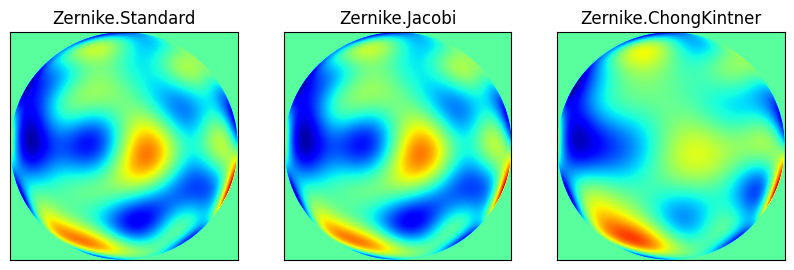

In [17]:

map1 = zern.invert_mask(r1, aperture_mask)
map2 = zern.invert_mask(r2, aperture_mask)
map3 = zern.invert_mask(r3, aperture_mask)
cmap = 'jet'

fig, axes = plt.subplots(1, 3, figsize=(10, 4))
ax1, ax2, ax3 = axes
ax1.imshow(map1, cmap=cmap)
ax2.imshow(map2, cmap=cmap)
ax3.imshow(map3, cmap=cmap)
ax1.set_title(r"Zernike.Standard")
ax2.set_title(r"Zernike.Jacobi")
ax3.set_title(r"Zernike.ChongKintner")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [7]:
# diff = map2 - map3
# np.max(np.abs(diff))
# plt.imshow(diff)
# plt.show()

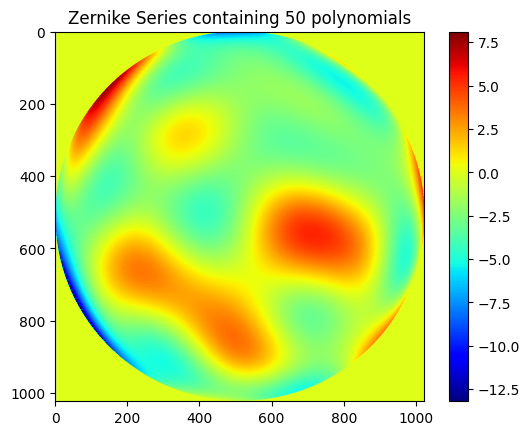

In [9]:
plt.figure()
plt.imshow(zern.invert_mask(z_series, aperture_mask), cmap='jet')
plt.title("Zernike Series containing %d polynomials" % N_zern)
plt.colorbar()
plt.show()

Text(0.5, 1.0, 'Time spent in each polynomial')

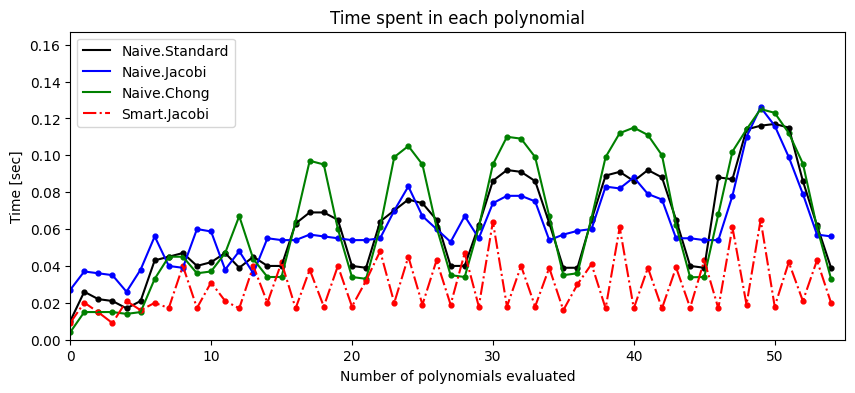

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.scatter(np.arange(len(times_naive)), times_naive, c='k', s=12)
ax.plot(np.arange(len(times_naive)), times_naive, c='k', label='Naive.Standard')

ax.scatter(np.arange(len(times_jacobi)), times_jacobi, c='b', s=12)
ax.plot(np.arange(len(times_jacobi)), times_jacobi, c='b', label='Naive.Jacobi')

ax.scatter(np.arange(len(times_chong)), times_chong, c='g', s=12)
ax.plot(np.arange(len(times_chong)), times_chong, c='g', label='Naive.Chong')

ax.scatter(np.arange(len(times_smart)), times_smart, c='r', s=12)
ax.plot(np.arange(len(times_smart)), times_smart, c='r', label='Smart.Jacobi', linestyle='-.')
ax.legend()
ax.set_xlim([0, len(times_naive)])
ax.set_ylim([0, max(times_naive) + 0.05])
ax.set_xlabel('Number of polynomials evaluated')
ax.set_ylabel('Time [sec]')
ax.set_title('Time spent in each polynomial')

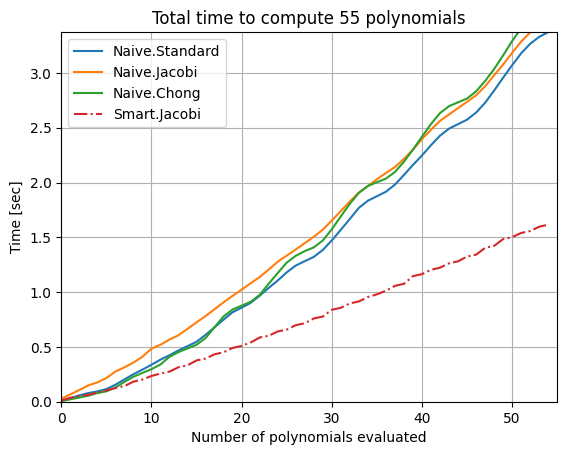

In [20]:
avg_naive = [np.sum(times_naive[:(i+1)]) for i in range(len(times_naive))]
avg_jacobi = [np.sum(times_jacobi[:(i+1)]) for i in range(len(times_jacobi))]
avg_chong = [np.sum(times_chong[:(i+1)]) for i in range(len(times_chong))]
avg_smart = [np.sum(times_smart[:(i+1)]) for i in range(len(times_smart))]

fig, ax = plt.subplots(1, 1)
ax.plot(np.arange(len(avg_naive)), avg_naive, label='Naive.Standard')
ax.plot(np.arange(len(avg_jacobi)), avg_jacobi, label='Naive.Jacobi')
ax.plot(np.arange(len(avg_chong)), avg_chong, label='Naive.Chong')
ax.plot(np.arange(len(avg_smart)), avg_smart, label='Smart.Jacobi', linestyle='-.')
ax.legend()
ax.set_xlim([0, len(times_naive)])
ax.set_ylim([0, max(avg_naive)])
ax.set_xlabel('Number of polynomials evaluated')
ax.set_ylabel('Time [sec]')
ax.set_title('Total time to compute %d polynomials' %(len(times_naive)))
ax.grid(True)
plt.show()

In [11]:
z_j = zern.ZernikeNaive(mask=aperture_mask, log_level=logging.INFO)
rj = z_j(coef=coef, rho=rho, theta=theta, normalize_noll=False, mode='Jacobi', print_option=None)

Hj = zern.invert_model_matrix(z_j.model_matrix, aperture_mask)

INFO: Creating ZernikeNaive instance
INFO: Creating ZernikeNaive instance



 Mode: Jacobi
Total time required to evaluate 55 Zernike polynomials = 3.398 sec
Average time per polynomials: 61.773 ms


In [12]:
z_c = zern.ZernikeNaive(mask=aperture_mask, log_level=logging.INFO)
rc = z_c(coef=coef, rho=rho, theta=theta, normalize_noll=False, mode='ChongKintner', print_option=None)

Hc = zern.invert_model_matrix(z_c.model_matrix, aperture_mask)

INFO: Creating ZernikeNaive instance
INFO: Creating ZernikeNaive instance
INFO: Creating ZernikeNaive instance



 Mode: ChongKintner
Total time required to evaluate 55 Zernike polynomials = 3.593 sec
Average time per polynomials: 65.332 ms


24 0.8610930974845261


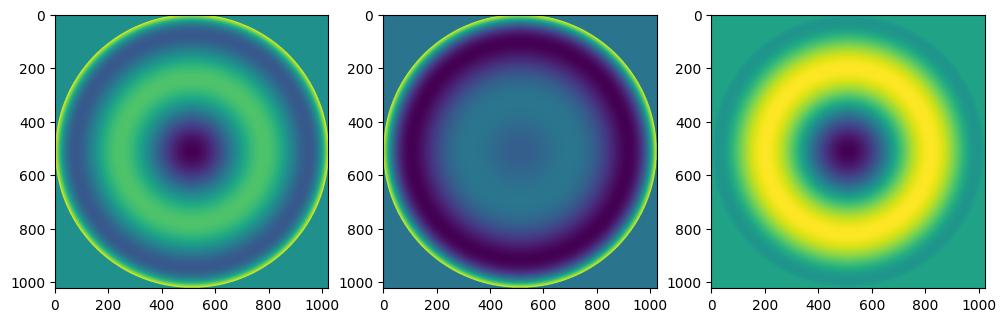

In [32]:
for k in range(N_zern):
    img_j = Hj[:, :, k]
    img_c = Hc[:, :, k]
    diff = img_j - img_c
    err = np.max(np.abs(diff))
    # print(err)
    if err > 0.1:
        print(k, err)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
        ax1.imshow(img_j)
        ax2.imshow(img_c)
        ax3.imshow(diff)
        plt.show()
        break


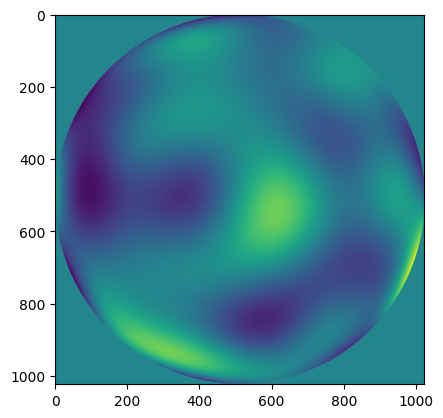

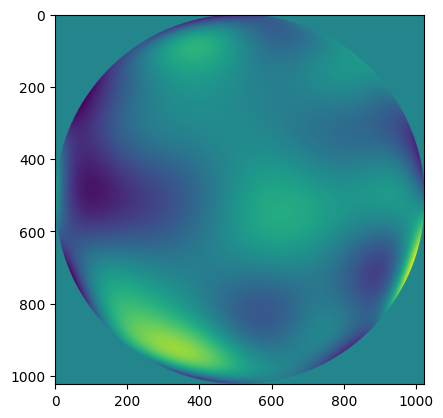

In [27]:
res_j = np.dot(Hj[:, :, :N_zern], coef)
res_c = np.dot(Hc[:, :, :N_zern], coef)
plt.figure()
plt.imshow(res_j)
plt.figure()
plt.imshow(res_c)
plt.show()

INFO: Creating ZernikeNaive instance
INFO: Creating ZernikeNaive instance
INFO: Creating ZernikeNaive instance
INFO: Creating ZernikeNaive instance
INFO: Creating ZernikeNaive instance


n=0, m=0
n=1, m=-1
n=1, m=1
n=2, m=-2
n=2, m=0
n=2, m=2
n=3, m=-3
n=3, m=-1
n=3, m=1
n=3, m=3
n=4, m=-4
n=4, m=-2
n=4, m=0
n=4, m=2
n=4, m=4
n=5, m=-5
n=5, m=-3
n=5, m=-1
n=5, m=1
n=5, m=3
n=5, m=5

 Mode: Jacobi
Total time required to evaluate 21 Zernike polynomials = 1.005 sec
Average time per polynomials: 47.845 ms


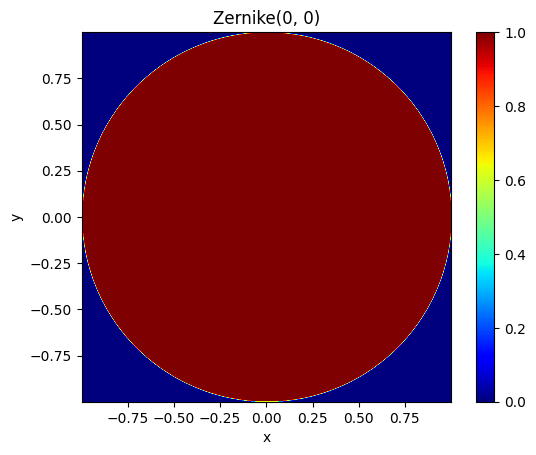

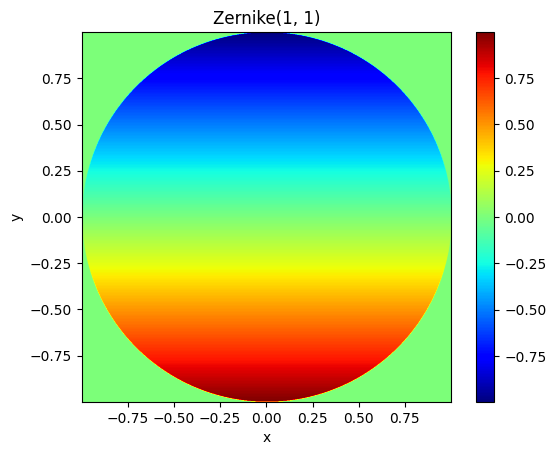

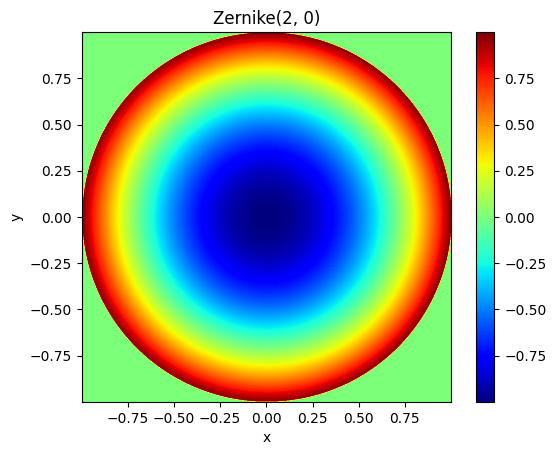

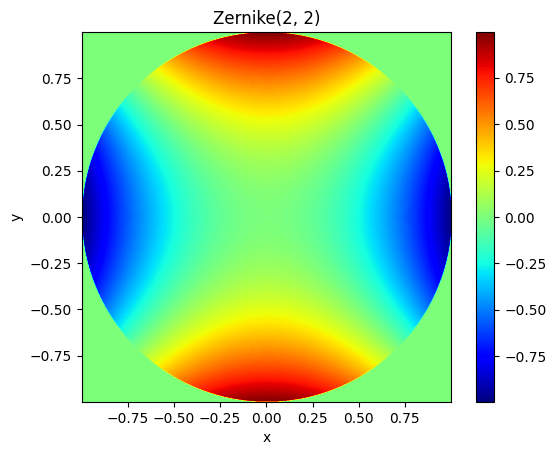

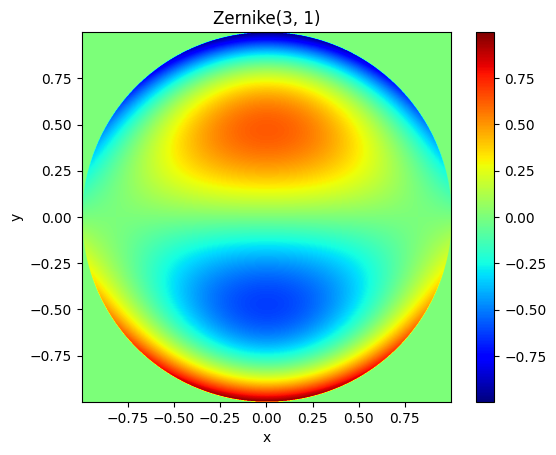

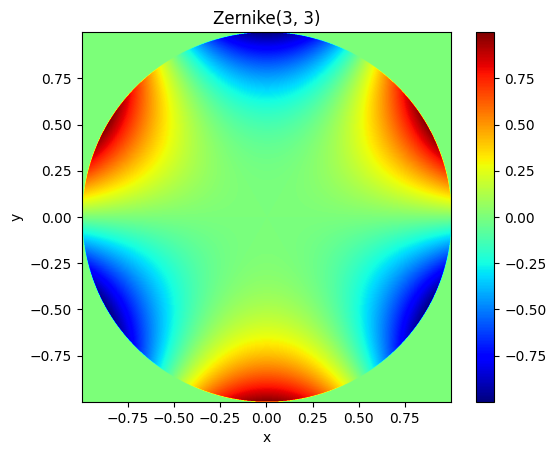

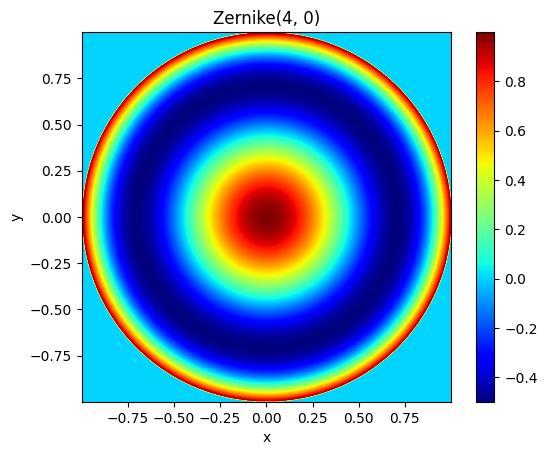

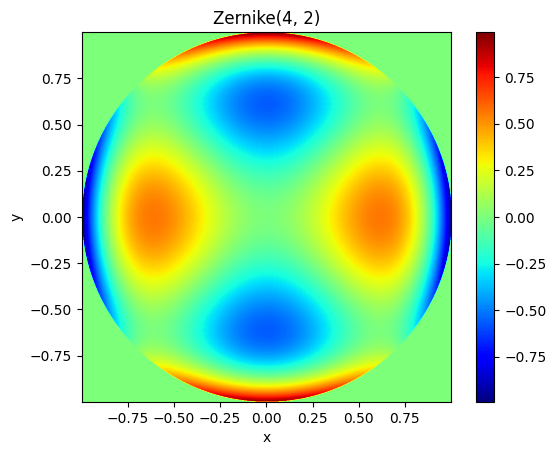

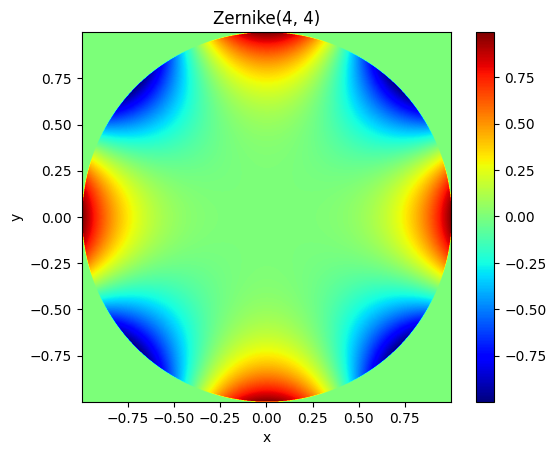

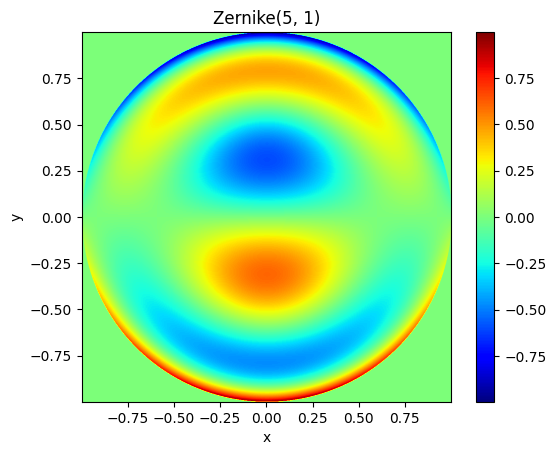

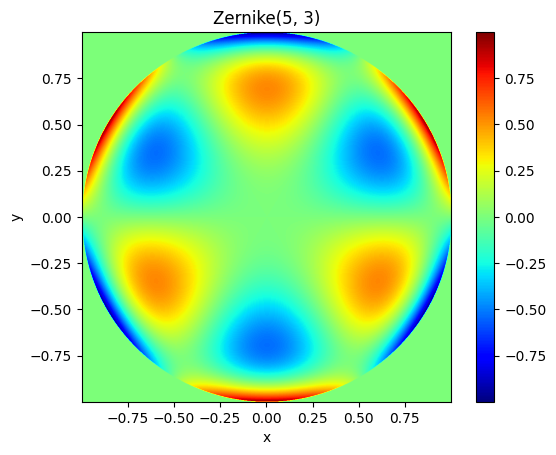

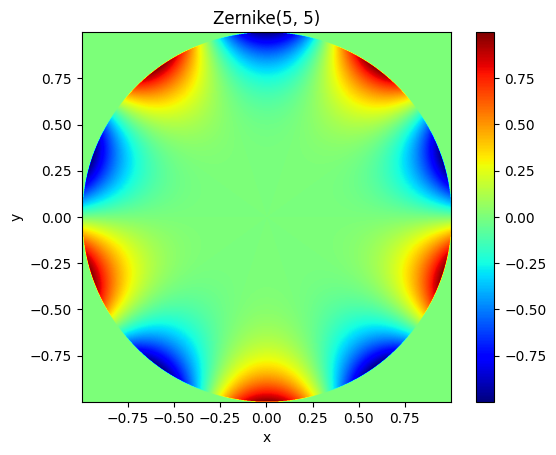

In [24]:
new_coef = np.zeros(20)

z_j = zern.ZernikeNaive(mask=aperture_mask, log_level=logging.INFO)
rj = z_j(coef=new_coef, rho=rho, theta=theta, normalize_noll=False, mode='Jacobi', print_option="All")

Hj = zern.invert_model_matrix(z_j.model_matrix, aperture_mask)

n=0, m=0
n=1, m=1
n=2, m=0
n=2, m=2
n=3, m=1
n=3, m=3
n=4, m=0
n=4, m=2
n=4, m=4
n=5, m=1
n=5, m=3
n=5, m=5

 Mode: Improved Jacobi 
Total time required to evaluate 21 Zernike polynomials = 0.544 sec
Average time per polynomials: 25.891 ms


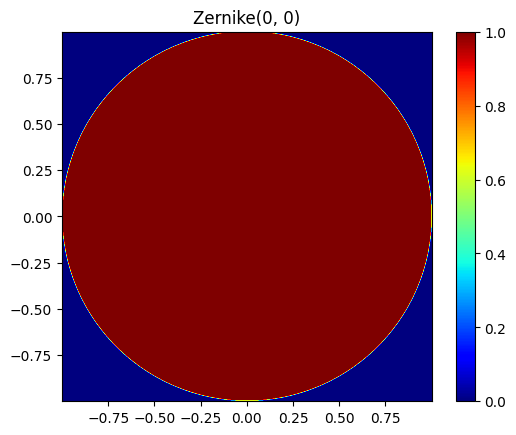

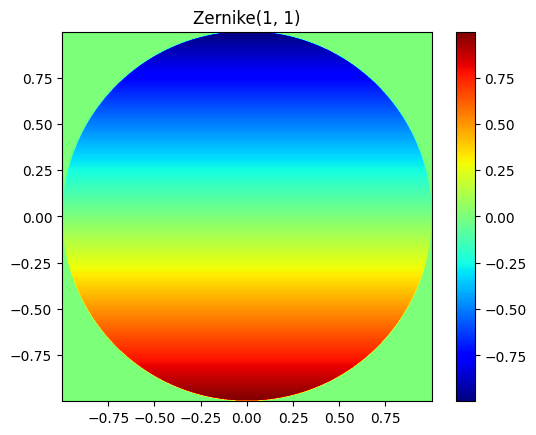

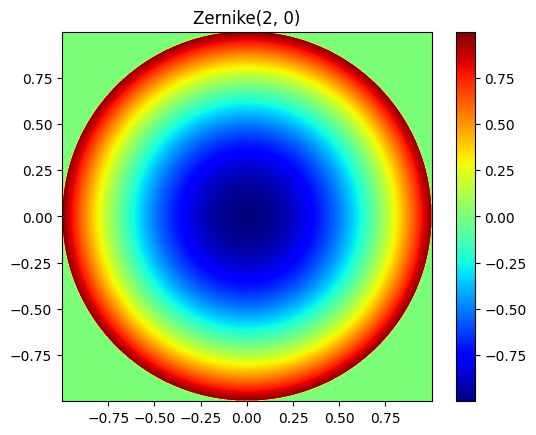

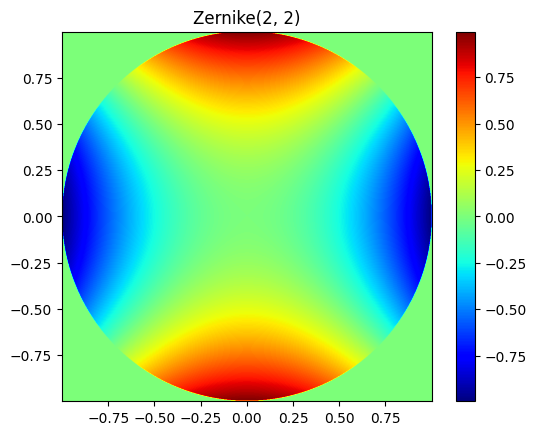

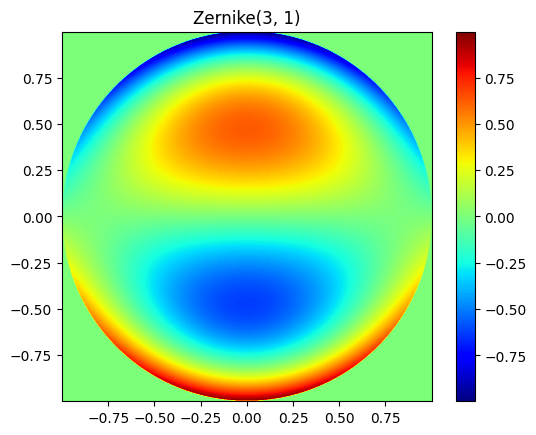

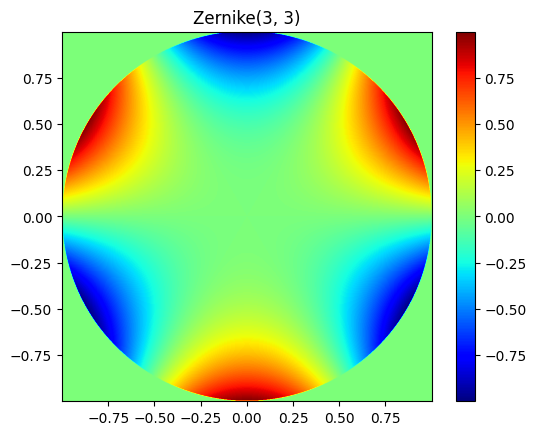

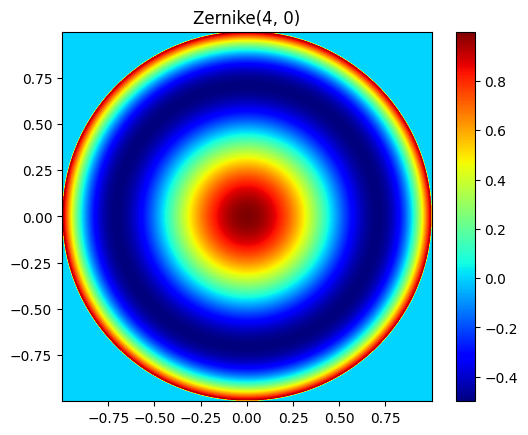

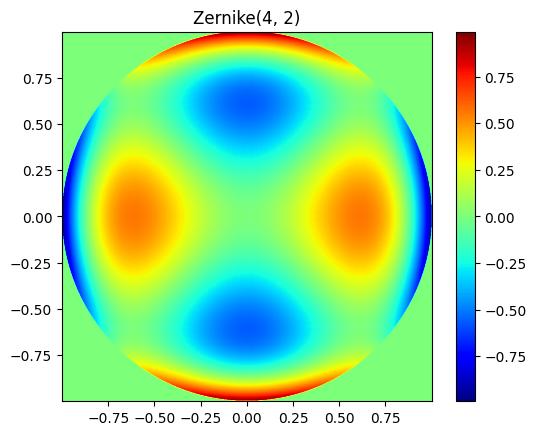

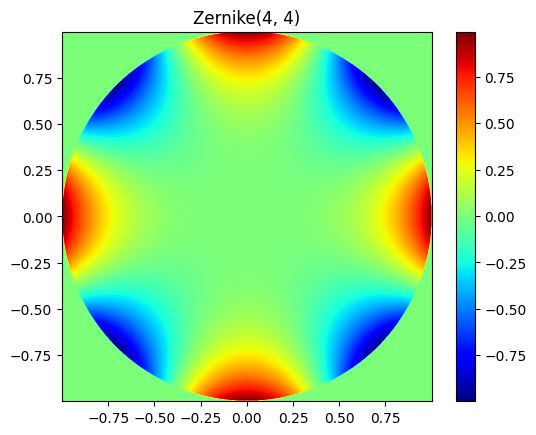

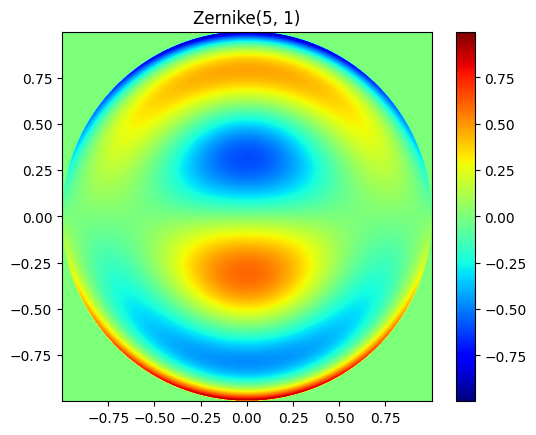

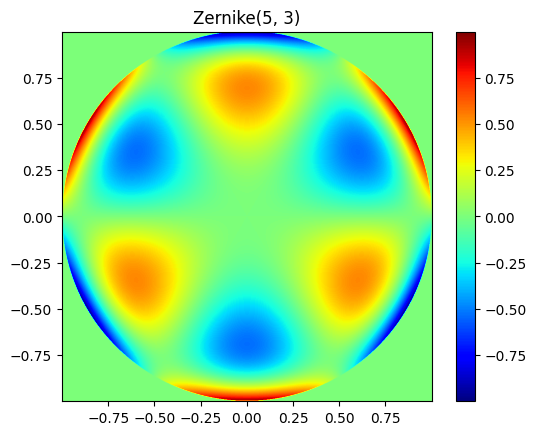

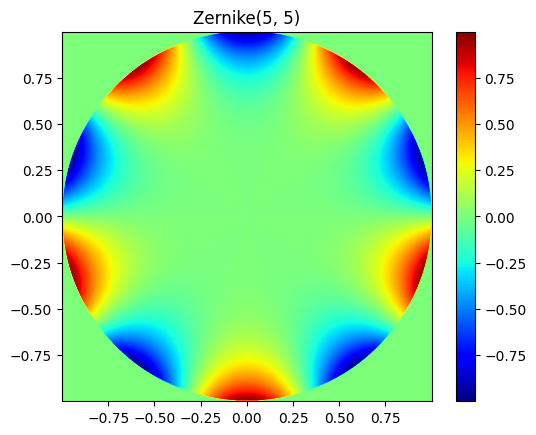

In [25]:
z_smart = zern.ZernikeSmart(mask=aperture_mask)
z_series = z_smart(new_coef, rho, theta, normalize_noll=False, print_option="All")
# Hs = zern.invert_model_matrix(z_smart.model_matrix, aperture_mask)

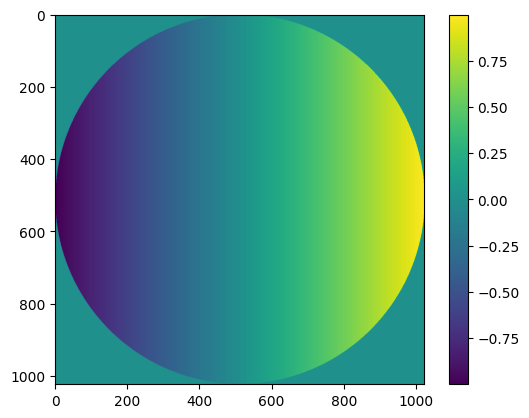

In [36]:
plt.imshow(H1[:,:, 1])
plt.colorbar()
plt.show()

In [58]:
_rho = np.linspace(0, 1, 100)
n = 4
rr = z_j.R_nm_ChongKintner(n=n, m=0, rho=_rho)
rr2 = z_j.R_nm_Jacobi(n=n, m=0, rho=_rho)

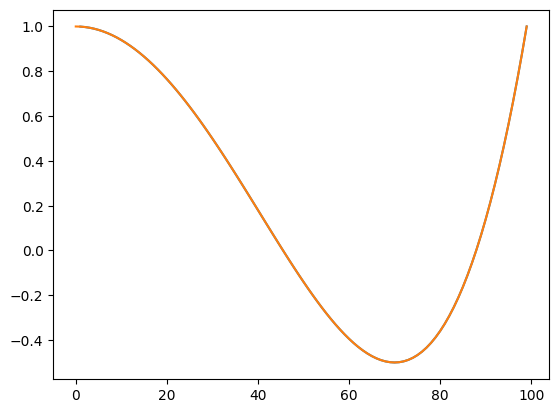

In [59]:
fig, ax = plt.subplots(1,1)
ax.plot(rr)
ax.plot(rr2)